In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from random import randint
from tqdm import tqdm, trange
import time
import skvideo.io
from scipy.spatial import Delaunay
from skimage import transform as tf

In [2]:
image1 = plt.imread("M1.jpg")
image2 = plt.imread("M2.jpg")
print(image1.shape)
print(image2.shape)

(940, 600, 3)
(940, 600, 3)


In [3]:
points = []
def mouse_callback(event,x,y,flags,param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(img_tmp, (x, y), 5, (0, 255, 0), -1)
        points.append([y, x])


# h, w = (600,600)
# finished = False
# img_tmp = image1.copy()
# cv.destroyAllWindows()
# cv.namedWindow('image', cv.WINDOW_NORMAL)
# cv.setWindowTitle("image", "Press Esc to close and Left mouse to select point")
# cv.resizeWindow('image', w, h) #Reasonable size window
# cv.setMouseCallback('image', mouse_callback) #Mouse callback
# while(not finished):
#     cv.imshow('image', img_tmp)
#     k = cv.waitKey(4) & 0xFF
#     if k == 27:
#         break

# points1 = points.copy()
# points = []
# img_tmp = image2.copy()
# finished = False
# cv.namedWindow('image2', cv.WINDOW_NORMAL)
# cv.setWindowTitle("image2", "Press Esc to close and Left mouse to select point")
# cv.resizeWindow('image2', w, h) #Reasonable size window
# cv.setMouseCallback('image2', mouse_callback) #Mouse callback
# while(not finished):
#     cv.imshow('image2', img_tmp)
#     k = cv.waitKey(4) & 0xFF
#     if k == 27:
#         break

# points2 = points.copy()
# cv.destroyAllWindows()

# def generate_points(points, shape):
#     h, w = shape
#     cs = [[0, 0], [h, w], [0, w//2], [h, w//2], [h//2, 0], [h//2, w], [0, w], [h, 0]]
#     for c in cs:
#         points.append(c)
#     return np.array(points)

# points1 = generate_points(points1, image1.shape[:2])
# points2 = generate_points(points2, image2.shape[:2])

points1 = [[175,346],[349,182],[379,255],[381,415],[354,478],[388,107],[492,122],[497,300],[490,356],[498,393],[459,499],[366,511],[575,274],[570,354],[570,407],[686,3],[682,347],[735,361],[693,596],[0,0],[940,600],[0,300],[940,300],[470,0],[470,600],[0,600],[940,0]]
points2 = [[180,354],[372,170],[395,242],[405,426],[391,490],[372,102],[533,122],[515,272],[517,335],[527,388],[555,511],[422,545],[597,243],[602,334],[596,417],[793,3],[728,318],[819,330],[776,596],[0,0],[940,600],[0,300],[940,300],[470,0],[470,600],[0,600],[940,0]]

t_p1 = []
for p in points1:
    t_p1.append([p[1], p[0]])
t_p2 = []
for p in points2:
    t_p2.append([p[1], p[0]])
t_p1 = np.array(t_p1)
t_p2 = np.array(t_p2)


<div dir="rtl">
طبق خواسته سوال، نقاط را از ورودی دریافت می کنیم البته برای سادگی، نقاط پیش فرضی را نیز قرار داده ایم که با عکس ها ست شده است
</div>




In [9]:
# for a in points1:
#     print(f"[{a[0]},{a[1]}],")
# print("ssssssssssssss")
# for a in points2:
#     print(f"[{a[0]},{a[1]}],")

In [4]:
def transwarp(img, points, tpoints, tris):
    res = np.zeros((img.shape[0] * img.shape[1], 3))
    affines = []
    for tri in tris.vertices:
        affine = tf.AffineTransform()
        affine.estimate(points[tri, :], tpoints[tri, :])
        
        mask = np.zeros((img.shape[0], img.shape[1]))
        cv.fillConvexPoly(mask, tpoints[tri, :], 1)
        mask = mask.astype(np.bool)
        out = tf.warp(img, affine.inverse, output_shape=(img.shape[0], img.shape[1]))
        
#         print(out[:, :, 0].flatten().shape)
#         print(mask.flatten().shape)
        r = out[:,:,0].flatten()[mask.flatten()]
        g = out[:,:,1].flatten()[mask.flatten()]
        b = out[:,:,2].flatten()[mask.flatten()]
#         print(np.dstack([r, g, b]))
        res[mask.flatten()] = np.dstack([r, g, b])
#         plt.imshow(out)
#         plt.show()
#         plt.imshow(mask[:, :])
#         plt.show()
#         plt.imshow(np.reshape(res, (img.shape[0], img.shape[1], img.shape[2])))
#         plt.show()
        
    return np.reshape(res, (img.shape[0], img.shape[1], img.shape[2]))

<div dir="rtl">
در اینجا تابعی نوشته ایم تا با دریافت عکس و نقاط رئوس مثلث و نقاط رئوس مثلث در شکل نهایی و همچنین مثلث بندی عکس اول، تصویر را به مثلث ها بشکند و هر مثلث را با تبدیل آفین منتقل کند و یک عکس منتقل شده کامل خروجی دهد. برای اینکار از وارپ و تبدیل آفین کتاب خانه های موجود استفاده کرده ایم 
</div>




In [6]:
tris = Delaunay(points1)
res = transwarp(image1.copy(), t_p1, t_p2, tris)

In [10]:
# plt.figure(figsize=(10,10))
# plt.imshow(res)

In [11]:
def morph2(img1, img2, points1, points2, alpha):
    tris = Delaunay(points1)
    t_points = []
    t_points = np.array((1 - alpha) * t_p1 + alpha * t_p2, np.int)
    img1t = transwarp(img1, t_p1, t_points, tris)
    imgt2 = transwarp(img2, t_p2, t_points, tris)
#     plt.imshow(img1t)
#     plt.show()
#     plt.imshow(imgt2)
#     plt.show()
    return (1 - alpha) * img1t + alpha * imgt2

<div dir="rtl">
تابع بالا تصویر اول و نهایی را به همراه نقاط رئوس مثلث ها می گیرد دریافت می کند و همچنین مقدار آلفا که همان فاصله تصویر خروجی از تصویر اول است که بین صفر تا یک تعریف می شود را می گیرد تا تصویر در زمان آلفا را برگرداند
</div>




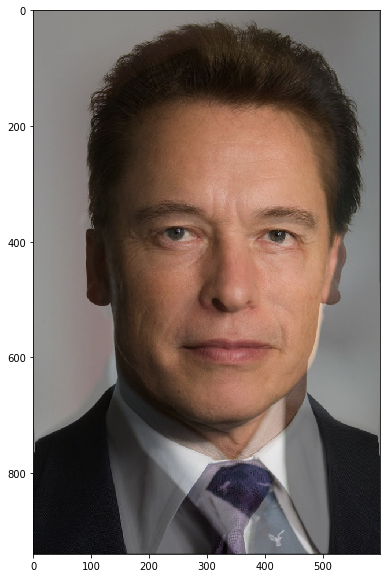

In [16]:
img3 = morph2(image1, image2, t_p1, t_p2, 0.5)
plt.figure(figsize=(10, 10))
plt.imshow(img3)

In [19]:
iter_num = 20
codec = cv.VideoWriter_fourcc(*"DIVX")
writer = skvideo.io.FFmpegWriter("movie01.mp4")

for i in trange(iter_num + 1):
    img3 = morph2(image1, image2, t_p1, t_p2, i/iter_num)
    for j in range(5):
        writer.writeFrame(np.array(img3*255, np.uint8))
writer.close()
    
# plt.imshow(img3)

100%|██████████| 21/21 [03:39<00:00, 10.45s/it]


<div dir="rtl">
در اینجا نیز طی ۲۰ مرحله تصویر را تبدیل و ویدیو آن را می سازیم
</div>




In [14]:
def morph(img1, img2, points1, points2, alpha):
    t_points = []
    t_points = np.array((1 - alpha) * points1 + alpha * points2, np.int)
    trans_1t = tf.PiecewiseAffineTransform()
    trans_1t.estimate(points1, t_points)
    img1t = tf.warp(img1, trans_1t.inverse, output_shape=(img1.shape[0], img1.shape[1]))
    trans_t2 = tf.PiecewiseAffineTransform()
    trans_t2.estimate(points2, t_points)
    imgt2 = tf.warp(img2, trans_t2.inverse, output_shape=(img2.shape[0], img2.shape[1]))
#     plt.imshow(img1t)
#     plt.show()
#     plt.imshow(imgt2)
#     plt.show()
    return (1 - alpha) * img1t + alpha * imgt2

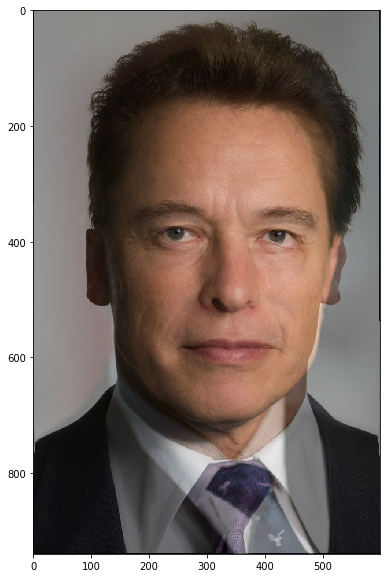

In [18]:
img3 = morph(image1, image2, t_p1, t_p2, 0.5)
plt.figure(figsize=(10, 10))
plt.imshow(img3)

In [15]:
iter_num = 20
codec = cv.VideoWriter_fourcc(*"DIVX")
writer = skvideo.io.FFmpegWriter("movie01.mp4")

for i in trange(iter_num + 1):
    img3 = morph(image1, image2, t_p1, t_p2, i/iter_num)
    for j in range(5):
        writer.writeFrame(np.array(img3*255, np.uint8))
writer.close()

100%|██████████| 21/21 [00:34<00:00,  1.62s/it]


<div dir="rtl">
یک پیاده سازی دیگر از این تمرین با استفاده از کتاب خانه آماده مربوط به تبدیل آفین به صورت قطعه قطعه که خودش مثلث بندی می کند و منتقل می کند را آورده ایم، که می توان کیفیت تصویر خروجی ما و آن را مقایسه کنید و ببینید که هر دو یکسان است و فقط کمی از نظر سرعت بهتر از کد ما عمل می کند
</div>


